In [1]:
import os
cwd = os.getcwd()
cwd
os.chdir("D:\data science")

# Importing libraries
NUMPY, PANDAS, PYMC3, PYPLOT

In [2]:
import numpy as np
import pandas as pd
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
import pymc3 as pm, theano.tensor as tt
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
%matplotlib inline

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\ProgramData\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Reading dataset

In [94]:
df_all = pd.read_csv('nflscores.csv')
df_all

# Developing a result table 
This consists of columns like index, Home team, Away team, Home score, Away Score and the score difference.

In [5]:
# results table
df_all['game'], df_all['difference'] = df_all['team_home'] + ' - ' + df_all['team_away'], df_all['score_home'] - df_all['score_away']
df_all['games'] = list(zip(df_all['game'], df_all['score_home'], df_all['score_away'], df_all['difference']))
df_all['games']

0         (Miami Dolphins - Oakland Raiders, 14, 23, -9)
1           (Houston Oilers - Denver Broncos, 45, 7, 38)
2        (San Diego Chargers - Buffalo Bills, 27, 7, 20)
3           (Miami Dolphins - New York Jets, 14, 19, -5)
4       (Green Bay Packers - Baltimore Colts, 24, 3, 21)
5          (Houston Oilers - Oakland Raiders, 31, 0, 31)
6      (San Diego Chargers - New England Patriots, 24...
7       (Atlanta Falcons - Los Angeles Rams, 14, 19, -5)
8      (Buffalo Bills - Kansas City Chiefs, 20, 42, -22)
9             (Detroit Lions - Chicago Bears, 14, 3, 11)
10     (Pittsburgh Steelers - New York Giants, 34, 34...
11     (San Francisco 49ers - Minnesota Vikings, 20, ...
12     (St. Louis Cardinals - Philadelphia Eagles, 16...
13     (Washington Redskins - Cleveland Browns, 14, 3...
14        (Los Angeles Rams - Chicago Bears, 31, 17, 14)
15          (Buffalo Bills - Miami Dolphins, 58, 24, 34)
16     (Cleveland Browns - Green Bay Packers, 20, 21,...
17         (Dallas Cowboys - Ne

Trying Data Exploration

In [6]:
[game for game in list(zip(df_all['game'], df_all['score_home'], df_all['score_away'], df_all['difference'])) if "New England Patriots" in game[0]]

[('San Diego Chargers - New England Patriots', 24, 0, 24),
 ('Denver Broncos - New England Patriots', 10, 24, -14)]

Now we take the score difference every team has and grouping them together in a table using Panda Groupby API

In [7]:
df_away_count = df_all.groupby('team_away')['difference'].count()
df_home_count = df_all.groupby('team_home')['difference'].count()
df_away_diff = df_all.groupby('team_away')['difference'].sum()
df_home_diff = df_all.groupby('team_home')['difference'].sum()
df_away_var = df_all.groupby('team_away')['difference'].var()
df_home_var = df_all.groupby('team_home')['difference'].var()
df_home_diff

team_home
Atlanta Falcons       -237
Baltimore Colts        146
Boston Patriots         -8
Buffalo Bills           19
Chicago Bears           63
Cleveland Browns       109
Dallas Cowboys         196
Denver Broncos         -21
Detroit Lions          -45
Green Bay Packers      220
Houston Oilers          69
Los Angeles Rams       152
Miami Dolphins         -14
Minnesota Vikings       -8
New Orleans Saints     -83
New York Giants        -98
New York Jets           39
Oakland Raiders        -31
Philadelphia Eagles     25
Pittsburgh Steelers     -3
San Diego Chargers      78
San Francisco 49ers     15
St. Louis Cardinals     25
Washington Redskins     24
Name: difference, dtype: int64

# Computing mean and standard deviation for many games by the formula of a gaussian. 

In [8]:
df_team_mean = (df_home_diff - df_away_diff)/(df_home_count + df_away_count)
df_team_std = np.sqrt(df_home_var.fillna(0) + df_away_var.fillna(0))/(df_home_count + df_away_count)
df_team_mean

Atlanta Falcons        -18.541667
Baltimore Colts         11.041667
Boston Patriots               NaN
Buffalo Bills           -2.400000
Chicago Bears           -1.500000
Cleveland Browns         6.916667
Dallas Cowboys          10.230769
Denver Broncos         -10.400000
Detroit Lions           -5.360000
Green Bay Packers       12.692308
Houston Oilers           0.571429
Kansas City Chiefs            NaN
Los Angeles Rams         9.400000
Miami Dolphins         -22.600000
Minnesota Vikings       -3.041667
New England Patriots          NaN
New Orleans Saints     -13.400000
New York Giants        -11.458333
New York Jets           11.600000
Oakland Raiders         -3.666667
Philadelphia Eagles     -0.750000
Pittsburgh Steelers     -2.833333
San Diego Chargers      13.800000
San Francisco 49ers     -2.166667
St. Louis Cardinals     -0.320000
Washington Redskins      0.250000
Name: difference, dtype: float64

Plotting the MEAN picture

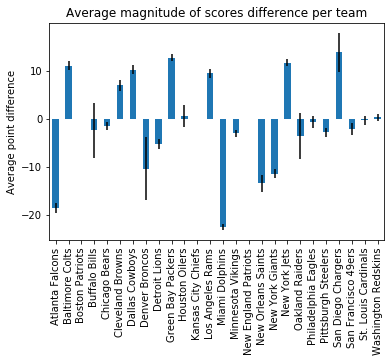

In [9]:
(df_team_mean

      .plot(kind='bar', title='Average magnitude of scores difference per team', yerr=df_team_std)
      .set_ylabel('Average point difference'));

# Building  a bayesian model for estimation. 

We build a simple model in PyMC3, specifying global parameters, team-specific parameters, and the likelihood function. Specifying a simple model along with parameters

In [10]:
df = df_all[['team_home', 'team_away', 'score_home', 'score_away']]
df.head()

,team_home,team_away,score_home,score_away
0,Miami Dolphins,Oakland Raiders,14,23
1,Houston Oilers,Denver Broncos,45,7
2,San Diego Chargers,Buffalo Bills,27,7
3,Miami Dolphins,New York Jets,14,19
4,Green Bay Packers,Baltimore Colts,24,3


Indexing the teams.

In [11]:
teams = df['team_home'].unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index
teams

,team,i
0,Miami Dolphins,0
1,Houston Oilers,1
2,San Diego Chargers,2
3,Green Bay Packers,3
4,Atlanta Falcons,4
5,Buffalo Bills,5
6,Detroit Lions,6
7,Pittsburgh Steelers,7
8,San Francisco 49ers,8
9,St. Louis Cardinals,9


Indexing the matches

In [12]:
df = pd.merge(df, teams, left_on='team_home', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='team_away', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)
df.head()

,team_home,team_away,score_home,score_away,i_home,i_away
0,Miami Dolphins,Oakland Raiders,14,23,0,17.0
1,Houston Oilers,Denver Broncos,45,7,1,14.0
2,San Diego Chargers,Buffalo Bills,27,7,2,5.0
3,Miami Dolphins,New York Jets,14,19,0,16.0
4,Green Bay Packers,Baltimore Colts,24,3,3,19.0


# Calculating number of teams and games

In [47]:
observed_home_scores = df['score_home'].values
observed_away_scores = df['score_away'].values

teamhome = df['i_home'].values
teamaway = df['i_away'].values

num_teams = len(teams)
num_games = len(teamaway)
num_teams, num_games

(24, 217)

# Flashing out the indexes of Home and Away teams as per matches.

In [48]:
teamhome

array([ 0,  1,  2,  0,  3,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11,  5, 12,
       13, 14, 15, 16, 17, 18,  7,  9, 19, 20,  5, 12, 13, 14,  6,  3, 17,
       18,  7, 11,  4, 20, 14,  3, 15, 21, 18,  2, 10, 12, 22, 13,  6,  8,
        9, 10,  4, 19, 22, 15, 21,  7,  9, 19, 20, 22, 12,  3, 21,  8, 10,
        4, 20, 13,  6, 11, 15, 18,  9, 19, 20, 22,  3, 21, 18,  7,  8,  4,
       20, 22, 12, 11, 15,  7, 10, 12,  6,  3, 11, 21,  7,  8, 13,  6, 19,
       22, 15,  9, 10, 19, 20, 12, 13,  3, 11, 15, 18, 19,  4, 13,  6, 21,
       18,  8,  9,  4, 22, 11, 21,  8, 10, 13,  3, 19, 12,  3, 15, 23, 18,
        7,  9, 11, 13,  6,  3, 23, 18,  7,  8, 19, 13,  3, 15, 23, 18,  9,
       10, 12,  4, 22,  6, 11, 15, 21, 10,  4, 19, 20, 22, 12, 13,  3, 18,
        7, 20, 12,  6, 11, 15, 21,  7,  8,  9,  4, 22, 23, 21, 18,  8, 10,
        9, 19, 20, 13,  6, 15, 23,  7,  8, 10,  4, 20, 22,  3, 11, 15, 23,
        9, 10,  4, 19, 20, 22, 12, 13,  3, 21, 18, 13,  6], dtype=int64)

In [53]:
import numpy as np
A = np.array(teamaway)

A = A.astype(int)
A
teamaway = A
teamaway


array([17, 14,  5, 16, 19, 17,  0, 11,  0, 22, 21, 15, 18, 12, 22,  0,  3,
       21,  0, 19,  1,  0,  4,  6, 10,  8,  0,  1,  9, 15, 16,  4, 11,  2,
       21, 10,  8, 13, 16,  1,  6, 22, 12,  9,  0,  7,  7, 19, 18, 11,  3,
       21,  4,  8,  6,  3, 11, 10, 18, 13, 15,  2, 11, 13,  4, 18,  6,  9,
       12, 17,  7,  3, 19,  8, 10, 22, 10, 14,  6, 15,  9, 13, 12, 11, 19,
        1,  8, 18, 21,  6,  9, 13, 10, 19, 22, 15,  4, 13, 18, 12,  8, 11,
        4,  3,  7, 21, 22,  5, 21,  9,  8,  6,  4,  7,  3,  9, 10, 15,  7,
       12, 22, 12,  7, 15,  3, 13, 19, 18,  3,  0,  4, 13,  6,  8, 11, 10,
       22, 21, 15, 21, 12, 22, 10, 19,  9,  4,  8, 11,  4, 22, 12,  7,  6,
       21,  7, 18, 19,  3,  8,  9, 23, 13, 10, 11,  0,  6,  9, 23, 15,  8,
       21, 17, 22,  4, 10, 19,  3, 13, 23, 18, 15, 11,  7, 12, 13,  6, 19,
        3,  3,  1,  4, 22, 21, 18, 12, 11,  9, 19,  0, 21, 12, 18,  6, 13,
        7,  8, 11,  6, 16,  9, 15, 10,  8,  7, 23,  9, 11])

# Scores for the home team 

In [39]:
observed_home_scores

array([14, 45, 27, 14, 24, 31, 24, 14, 20, 14, 34, 20, 16, 14, 31, 58, 20,
       52, 10, 23, 52, 10, 23, 17, 23, 36, 24, 27, 28, 28,  7, 28, 24, 20,
       35, 27, 34, 14, 24, 40, 23, 10,  7, 10, 44, 24, 41, 27, 56,  7, 21,
       24, 33,  7, 45,  0, 35, 13, 14, 10, 20, 35, 17, 30, 56,  3, 27, 26,
       17, 24, 52,  7,  3, 28, 13, 24, 37, 10, 10, 17, 17, 24, 16, 21,  7,
       27, 30, 27, 55, 31, 30, 30, 14, 20, 13, 21, 16,  7, 34, 26, 14,  7,
       23, 16,  6, 72, 21, 14, 49, 31, 20, 23, 13, 27, 10, 16, 31, 16, 28,
       33, 41, 10, 33, 41, 23,  7, 14, 28, 27, 35, 38, 14, 17, 21, 13, 35,
       41, 20, 39, 38, 31, 13, 10,  6, 14, 38, 41, 13, 23,  7,  7, 34, 38,
       38, 21,  7,  3, 17, 24, 24, 27, 14, 20, 24, 41, 14, 20, 14,  7, 27,
       24, 14, 24, 24, 28, 20, 21, 21, 27, 48, 21, 17, 10, 38, 21,  3, 13,
       23, 13, 18, 37, 13, 27, 31, 14,  7, 21,  7, 10, 34, 55, 33, 10, 10,
       14, 31,  3, 41, 24, 30, 14, 20, 13, 28, 48, 46,  7], dtype=int64)

# Marking down the priors.

We have calculated the priors for the home and away scores for each team using inverse exponential function.

In [40]:
g1 = df.groupby('i_away')
away_starting_points = np.log(g1['score_away'].mean())
g2 = df.groupby('i_home')
home_starting_points = -np.log(g2['score_home'].mean())
home_starting_points

i_home
0    -2.639057
1    -3.637586
2    -3.455265
3    -3.189888
4    -2.627081
5    -3.555348
6    -2.803360
7    -3.071921
8    -3.135494
9    -3.060271
10   -3.355735
11   -3.351498
12   -3.225520
13   -3.515801
14   -2.944439
15   -3.014780
16   -3.951244
17   -2.708050
18   -3.252162
19   -3.323236
20   -3.094823
21   -2.925115
22   -3.020425
23   -2.602690
Name: score_home, dtype: float64

# Model and Likelihood in pymc3

We have less than 30 data points so we used t-distribution because it gives a more accurate result with less data points.

In [18]:
import numpy as np

In [19]:
num_teams

24

In [69]:
with pm.Model() as model:
    home = pm.Flat('home') 
    sd_att = pm.HalfStudentT('sd_att', nu=3, sd=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sd=2.5)
    intercept = pm.Flat('intercept')

    # team-specific model parameters with the help of normal distribution 
    atts_star = pm.Normal("atts_star", mu=0, sd=sd_att, shape=num_teams)
    defs_star = pm.Normal("defs_star", mu=0, sd=sd_def, shape=num_teams)

    # We wrap the model parameters in pymc3 Deterministic objects for later.
    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    
    # Assume exponential search on home_theta and away_theta. With pymc3, need to rely on theano.
    # tt is theano.tensor.. why Sampyl may be easier to use..
    home_theta = tt.exp(intercept + home + atts[teamhome] + defs[teamaway])  
    away_theta = tt.exp(intercept + atts[teamaway] + defs[teamhome])

    # Poisson distribution for likelihood of observed data.
    home_points = pm.Poisson('home_scores', mu=home_theta, observed=observed_home_scores)
    away_points = pm.Poisson('away_scores', mu=away_theta, observed=observed_away_scores)

# Generating a trace plot using NUTS

Only 217 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [defs_star, atts_star, intercept, sd_def, sd_att, home]
Sampling 2 chains: 100%|██████████| 2434/2434 [19:47<00:00,  6.23draws/s] 
The number of effective samples is smaller than 25% for some parameters.
C:\ProgramData\Anaconda3\lib\site-packages\arviz\plots\traceplot.py:155: SyntaxWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (100), generating only 40 plots
  SyntaxWarning,


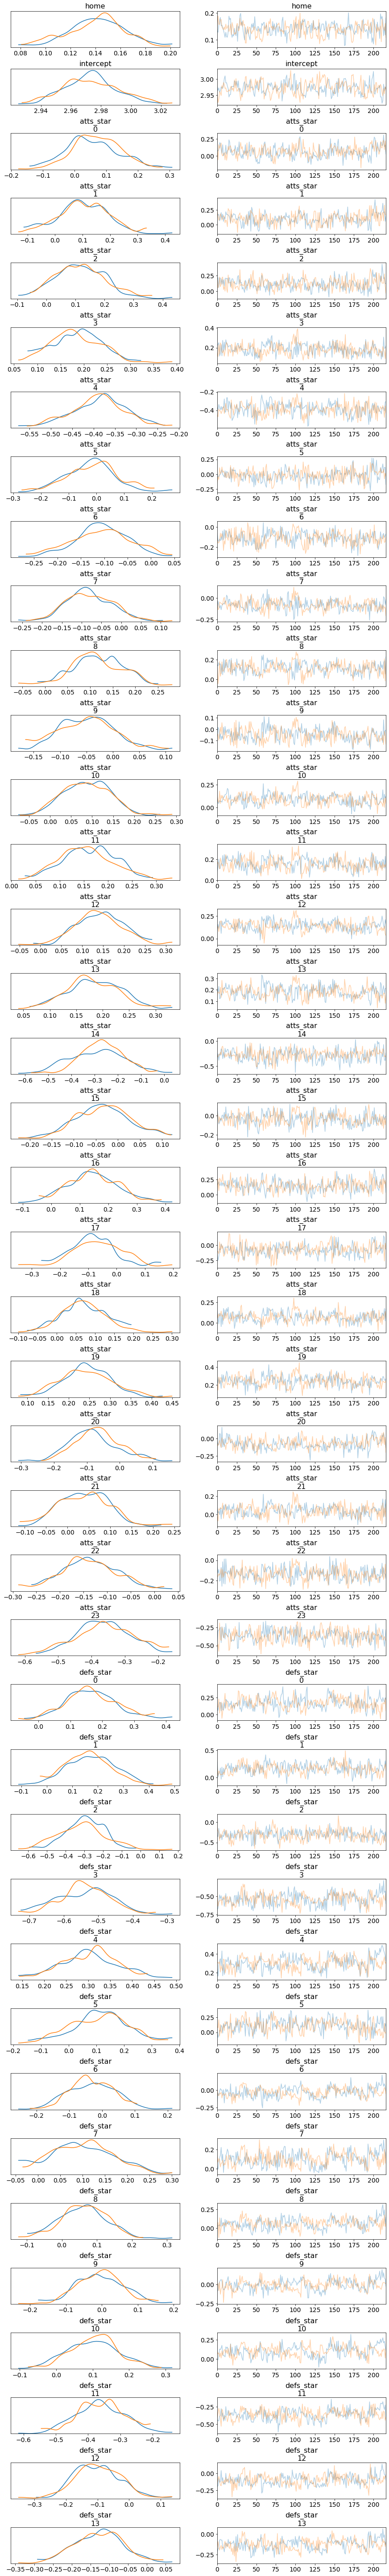

In [57]:
with model:
    trace = pm.sample(217, tune=1000, cores=2)
    pm.traceplot(trace)

# Calculating and Plotting Strengths 

Here we calculate the values of offense and defence and plotting graphs to find out the which teams are good at what.

In [59]:
pm.stats.hpd(trace['atts'])

array([[-0.06114193,  0.1984784 ],
       [-0.09706968,  0.24825632],
       [-0.02913422,  0.28223031],
       [ 0.08974084,  0.26374191],
       [-0.5130566 , -0.2932413 ],
       [-0.21676276,  0.13054585],
       [-0.20429234, -0.01181141],
       [-0.18699095,  0.01065679],
       [ 0.02513748,  0.21080282],
       [-0.14373762,  0.03556203],
       [ 0.01401467,  0.18023473],
       [ 0.05062721,  0.23618267],
       [ 0.05902893,  0.22838287],
       [ 0.09668419,  0.25774881],
       [-0.493148  , -0.09315637],
       [-0.14051094,  0.06510124],
       [-0.0168898 ,  0.29795395],
       [-0.23182833,  0.11168193],
       [-0.01988736,  0.15562174],
       [ 0.14776795,  0.33378739],
       [-0.20543547,  0.05153948],
       [-0.04450085,  0.13747448],
       [-0.2345058 , -0.02319661],
       [-0.51890652, -0.21020952]])

In [60]:
pm.stats.quantiles(trace['atts'])

{2.5: array([-0.06357118, -0.08471945, -0.02721859,  0.09016068, -0.50875303,
        -0.20014541, -0.21148787, -0.18699095,  0.00804743, -0.14491566,
        -0.00156589,  0.05667755,  0.05572231,  0.09727701, -0.48624067,
        -0.14028408, -0.01605146, -0.26731879, -0.02433416,  0.14199693,
        -0.20333764, -0.05561881, -0.24675148, -0.53724889]),
 25: array([ 0.00733092,  0.04703407,  0.05512871,  0.15273505, -0.42799756,
        -0.08276553, -0.14374202, -0.11588765,  0.08051293, -0.07927851,
         0.05288138,  0.12742601,  0.11256351,  0.15521356, -0.35473151,
        -0.07192521,  0.08395771, -0.13520751,  0.03452339,  0.209357  ,
        -0.12023904,  0.00115015, -0.17289196, -0.41505043]),
 50: array([ 0.06029819,  0.1015206 ,  0.11778984,  0.18461605, -0.38719921,
        -0.01376557, -0.10854322, -0.08378631,  0.11615896, -0.05098419,
         0.08549961,  0.15752245,  0.13750289,  0.18209322, -0.27792834,
        -0.03316077,  0.14364575, -0.07826972,  0.06882269, 

Plotting team vs attack strength

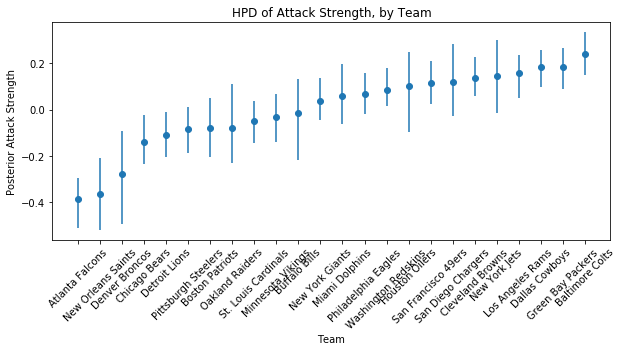

In [61]:
df_hpd = pd.DataFrame(pm.stats.hpd(trace['atts']),
                      columns=['hpd_low', 'hpd_high'],
                      index=teams.team.values)
df_median = pd.DataFrame(pm.stats.quantiles(trace['atts'])[50],
                         columns=['hpd_median'],
                         index=teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median,
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
             fmt='o')
axs.set_title('HPD of Attack Strength, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Attack Strength')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

Plotting team vs defense strength

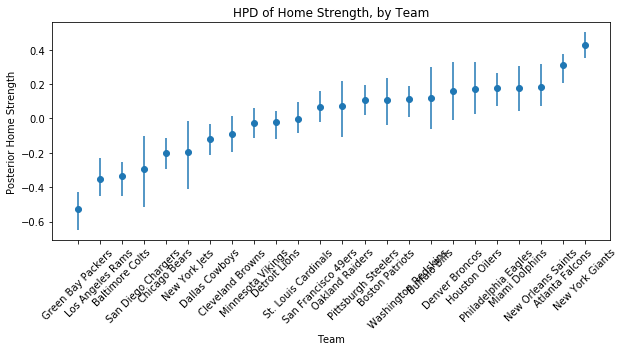

In [62]:
df_hpd = pd.DataFrame(pm.stats.hpd(trace['defs']),
                      columns=['hpd_low', 'hpd_high'],
                      index=teams.team.values)
df_median = pd.DataFrame(pm.stats.quantiles(trace['defs'])[50],
                         columns=['hpd_median'],
                         index=teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median,
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
             fmt='o')
axs.set_title('HPD of Home Strength, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Home Strength')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

Transposing

In [63]:
teams.T

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
team,Miami Dolphins,Houston Oilers,San Diego Chargers,Green Bay Packers,Atlanta Falcons,Buffalo Bills,Detroit Lions,Pittsburgh Steelers,San Francisco 49ers,St. Louis Cardinals,...,Denver Broncos,Minnesota Vikings,New York Jets,Oakland Raiders,Philadelphia Eagles,Baltimore Colts,Boston Patriots,New York Giants,Chicago Bears,New Orleans Saints
i,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23


# Plotting the attack.
Here we plot the attack strength of each and every team along with their mean scoring effect.

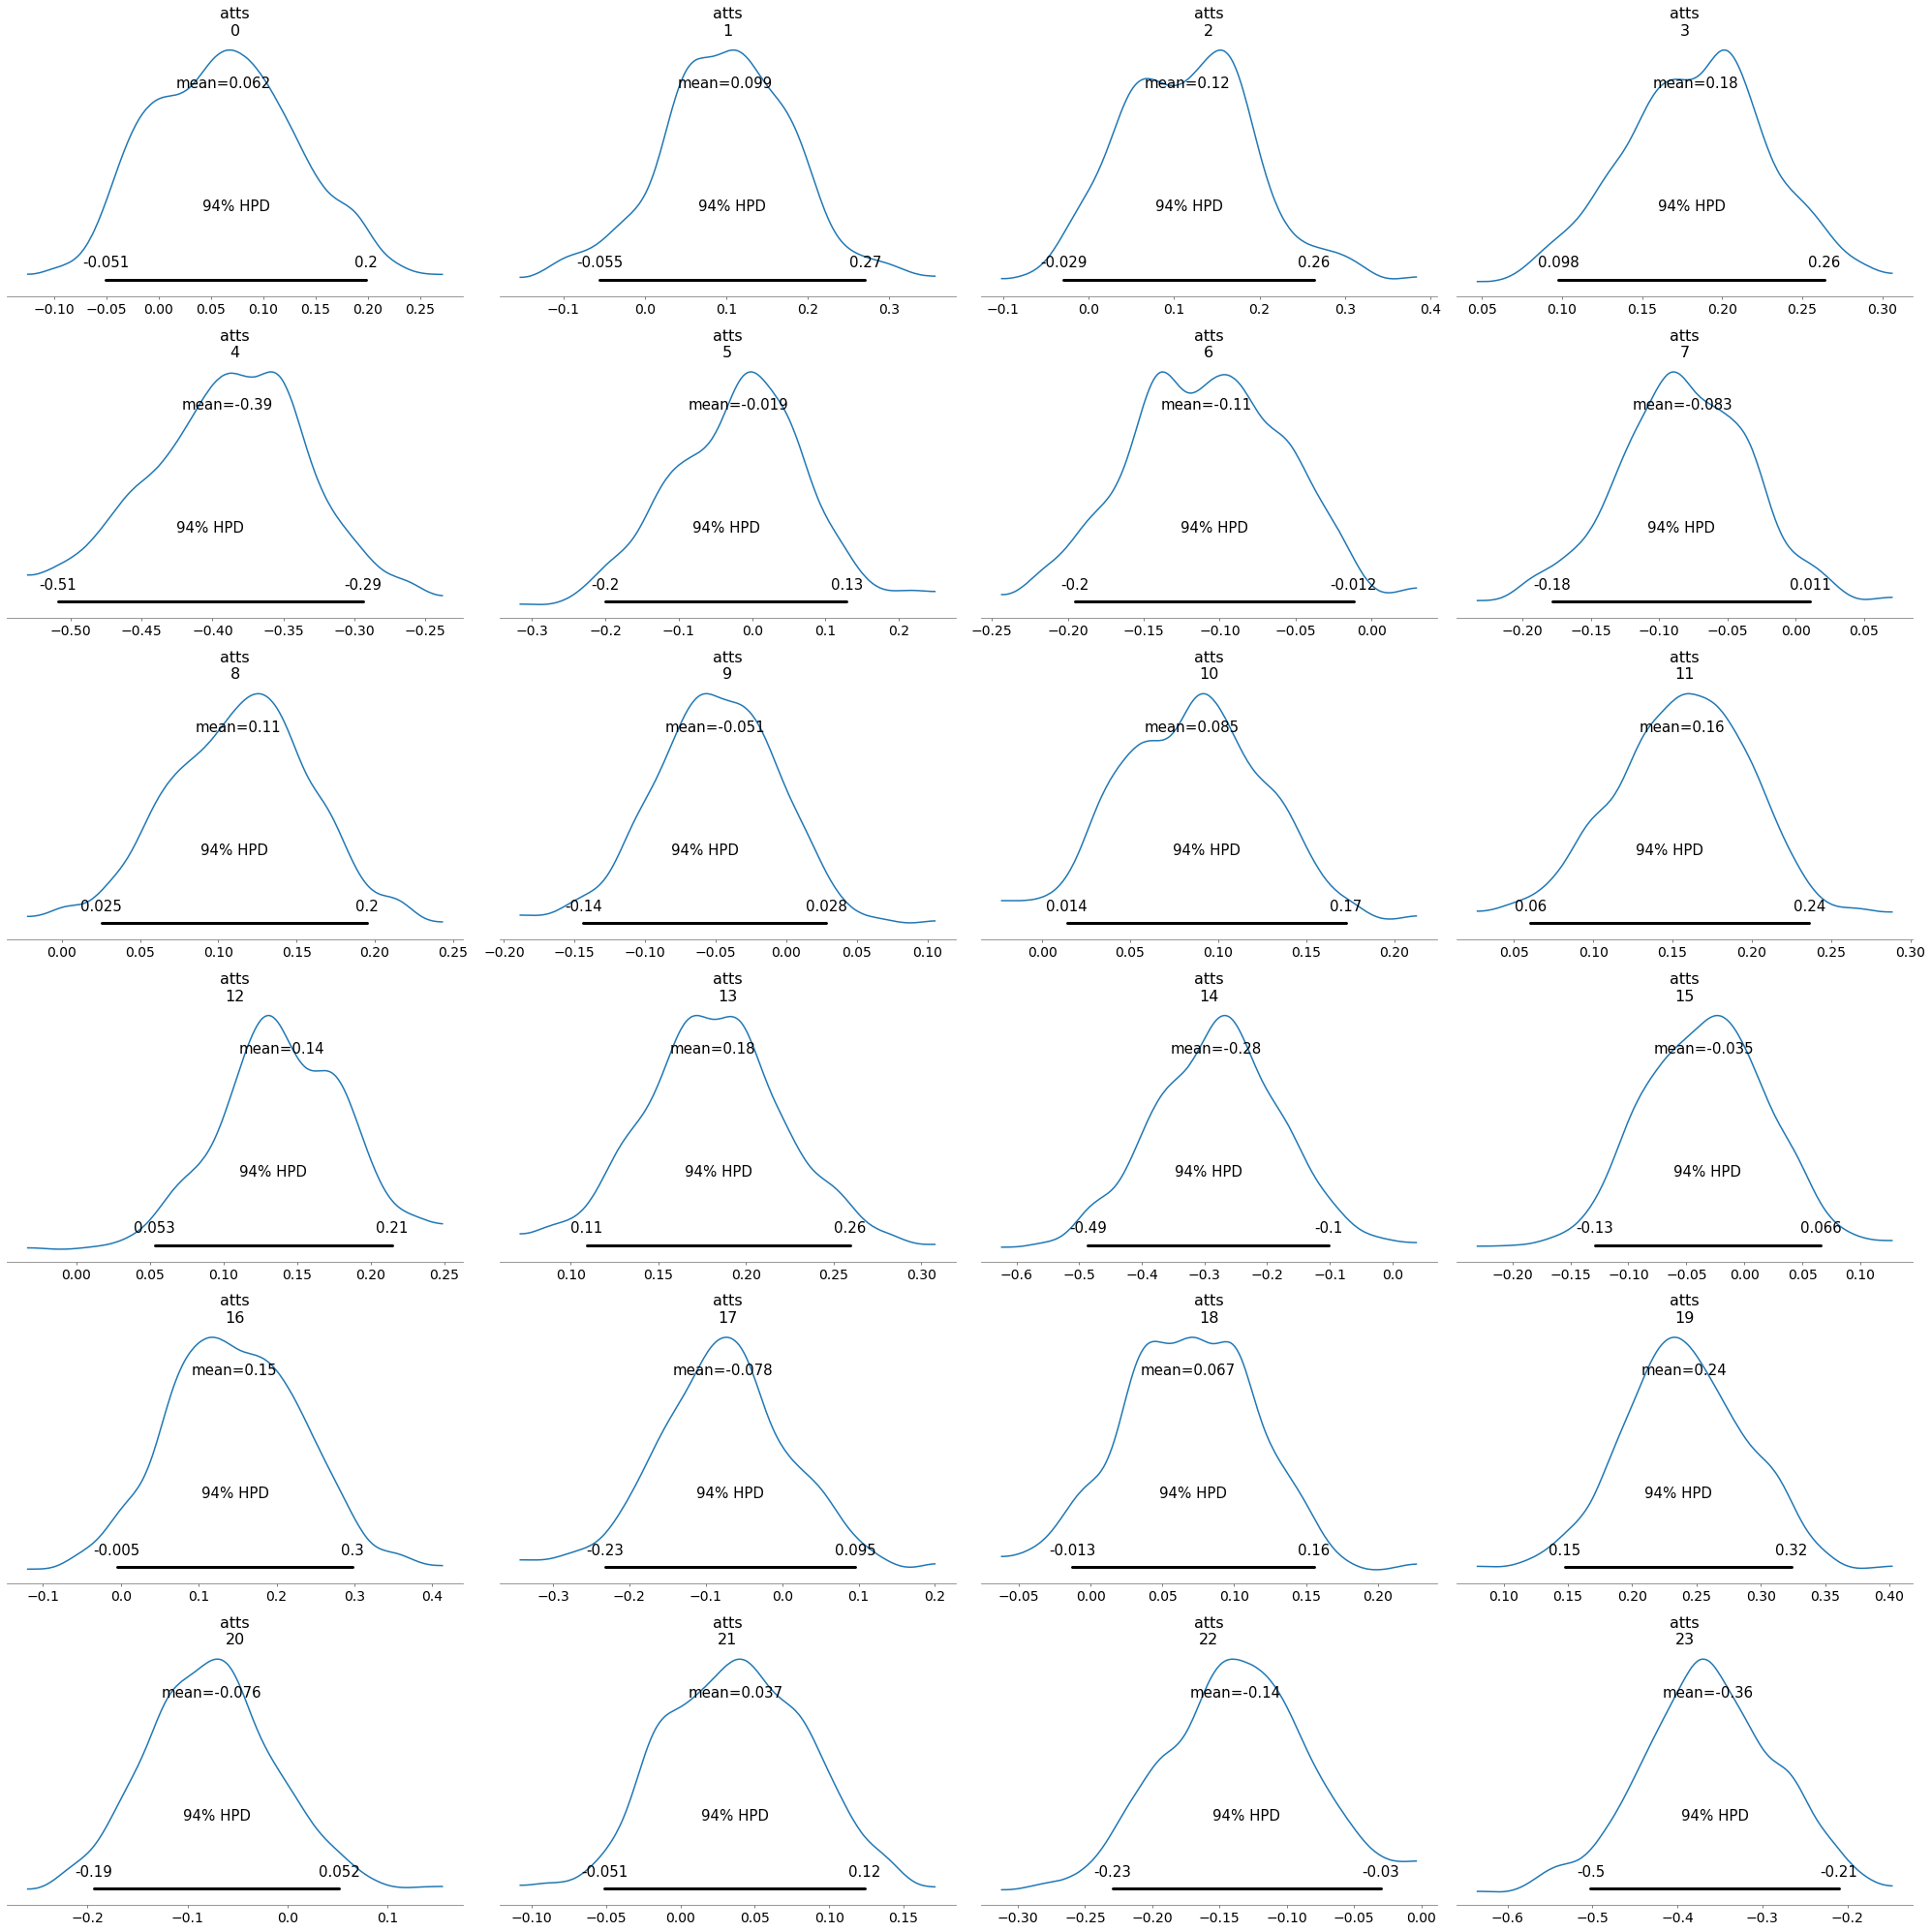

In [99]:
pm.plot_posterior(trace, varnames=['atts']);

We concluded that team number 19(Baltimore Colts) has the most positive attacking strength 0.24 and team number 4 (Atlanta Falcons) has the most negative attacking strength -0.39 .

# Predicting the future with Posterior Predictive Checks

In [66]:
with model:
    pp_trace = pm.sample_ppc(trace)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 434/434 [00:01<00:00, 234.32it/s]


In [80]:
home_sim_df = pd.DataFrame({
    'sim_points_{}'.format(i): 2 * home_won
        for i, home_won in enumerate(pp_trace['home_scores'] > pp_trace['away_scores'])
})
home_sim_df.insert(0, 'team', df['team_home'])

away_sim_df = pd.DataFrame({
    'sim_points_{}'.format(i): 2 * away_won
        for i, away_won in enumerate(pp_trace['home_scores'] < pp_trace['away_scores'])
})
away_sim_df.insert(0, 'team', df['team_away'])

In [81]:
sim_table = (home_sim_df.groupby('team')
                        .sum()
                        .add(away_sim_df.groupby('team')
                                        .sum())
                        .rank(ascending=False, method='min', axis=0)
                        .reset_index()
                        .melt(id_vars='team', value_name='rank')
                        .groupby('team')
                        ['rank']
                        .value_counts()
                        .unstack(level='rank')
                        .fillna(0)
                        .div(1000))

In [82]:
sim_table

rank,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0
team,,,,,,,,,,,,,,,,,,,,,
Atlanta Falcons,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.003,0.014,0.039,0.079,0.111,0.137,0.051
Baltimore Colts,0.053,0.100,0.126,0.120,0.033,0.002,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Buffalo Bills,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.009,0.014,0.062,0.076,0.102,0.093,0.048,0.018,0.008,0.003
Chicago Bears,0.000,0.000,0.000,0.001,0.002,0.050,0.055,0.048,0.083,0.064,...,0.002,0.004,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Cleveland Browns,0.002,0.034,0.059,0.109,0.211,0.016,0.002,0.000,0.001,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Dallas Cowboys,0.097,0.188,0.096,0.036,0.016,0.001,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Denver Broncos,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.001,0.006,0.014,0.020,0.062,0.100,0.104,0.101,0.026
Detroit Lions,0.000,0.000,0.000,0.000,0.000,0.001,0.001,0.012,0.022,0.032,...,0.034,0.025,0.012,0.007,0.001,0.000,0.000,0.000,0.000,0.000
Green Bay Packers,0.340,0.062,0.022,0.009,0.001,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


# Calculating the probabilities of teams finishing with maximum points.

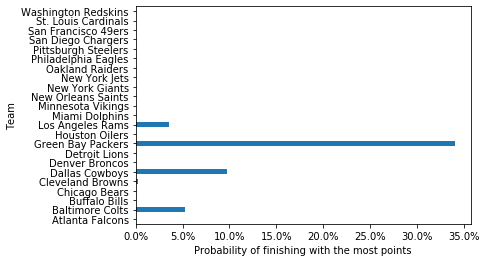

In [89]:
ax = sim_table.loc[:, 1.0].plot(kind='barh')

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1%}'));
ax.set_xlabel("Probability of finishing with the most points");

ax.set_ylabel("Team");

Conclusion : Here we predicted the probability of the team finishing with maximum points: 
       
The plot shows that Green Bay Packers have highest probability of finishing with around 34% chance , followed by Dallas Cowboys with 10% chance, Baltimore Colts with 5% chance, Los Angeles Rams with 4% chance and other teams contributing with veery less chances..
        

In [75]:
df_trace = pm.trace_to_dataframe(trace)

In [84]:
df_trace

,home,intercept,atts_star__0,atts_star__1,atts_star__2,atts_star__3,atts_star__4,atts_star__5,atts_star__6,atts_star__7,...,defs__14,defs__15,defs__16,defs__17,defs__18,defs__19,defs__20,defs__21,defs__22,defs__23
0,0.133454,2.976891,0.077114,0.196461,0.204182,0.216861,-0.364858,0.009304,-0.064258,-0.115695,...,0.291417,0.040222,-0.377614,0.055569,0.217848,-0.319705,0.004327,0.508563,-0.250006,0.193943
1,0.128606,2.964948,0.073240,0.160500,0.216359,0.234004,-0.392226,-0.047028,-0.130329,-0.038100,...,0.126242,-0.067877,-0.198350,0.051090,0.165835,-0.389107,0.093688,0.434026,-0.133813,0.323598
2,0.153030,2.972897,0.090206,0.173461,0.057755,0.250329,-0.336957,-0.040018,-0.142353,-0.079339,...,0.104046,-0.066811,-0.294352,-0.000582,0.133218,-0.292089,0.060819,0.385214,-0.155870,0.238602
3,0.174716,2.959779,0.191941,0.065730,0.211508,0.116270,-0.373727,-0.009380,-0.117802,-0.115322,...,0.097286,0.013841,-0.306049,0.041238,0.230356,-0.328525,0.195428,0.513749,-0.211716,0.214116
4,0.183672,2.963948,0.188655,0.097269,0.209423,0.140476,-0.394224,-0.007369,-0.135219,-0.086485,...,0.121358,-0.009926,-0.357574,-0.002645,0.224553,-0.314014,0.153409,0.439384,-0.214268,0.237204
5,0.152745,2.976271,0.095217,0.205682,0.108380,0.229501,-0.358143,0.044329,-0.093046,-0.136294,...,0.087806,0.028171,-0.187839,0.029869,0.245111,-0.280407,-0.009860,0.502439,-0.161566,0.216188
6,0.154809,2.971650,0.036416,0.104309,0.194265,0.118852,-0.394966,0.073905,-0.130163,-0.086442,...,0.059010,-0.051087,-0.420170,0.022367,0.190887,-0.360413,0.157148,0.499895,-0.221518,0.237573
7,0.146728,2.971421,0.164286,0.179077,0.111554,0.273763,-0.366091,-0.007818,-0.038250,-0.072391,...,0.218273,-0.004568,-0.174456,-0.000925,0.207708,-0.327864,0.107651,0.408529,-0.168415,0.202507
8,0.135012,2.980677,0.000798,0.055217,0.181490,0.163386,-0.372965,-0.021163,-0.125853,-0.061951,...,0.085695,-0.026515,-0.216052,0.111068,0.185227,-0.347615,0.116485,0.412091,-0.212088,0.160991
9,0.123969,3.001250,0.022275,0.128693,0.081025,0.256778,-0.276511,-0.049210,-0.024857,-0.068584,...,0.235393,-0.070813,-0.129183,0.040572,0.167985,-0.346330,0.140469,0.376597,-0.193932,0.146285


In [76]:
teams.T

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
team,Miami Dolphins,Houston Oilers,San Diego Chargers,Green Bay Packers,Atlanta Falcons,Buffalo Bills,Detroit Lions,Pittsburgh Steelers,San Francisco 49ers,St. Louis Cardinals,...,Denver Broncos,Minnesota Vikings,New York Jets,Oakland Raiders,Philadelphia Eagles,Baltimore Colts,Boston Patriots,New York Giants,Chicago Bears,New Orleans Saints
i,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23


Covariate Exploration
The covariate plots may seem unrelative at a look, but they give the idea of a team's defense and attacks over other teams used in covariate plots.

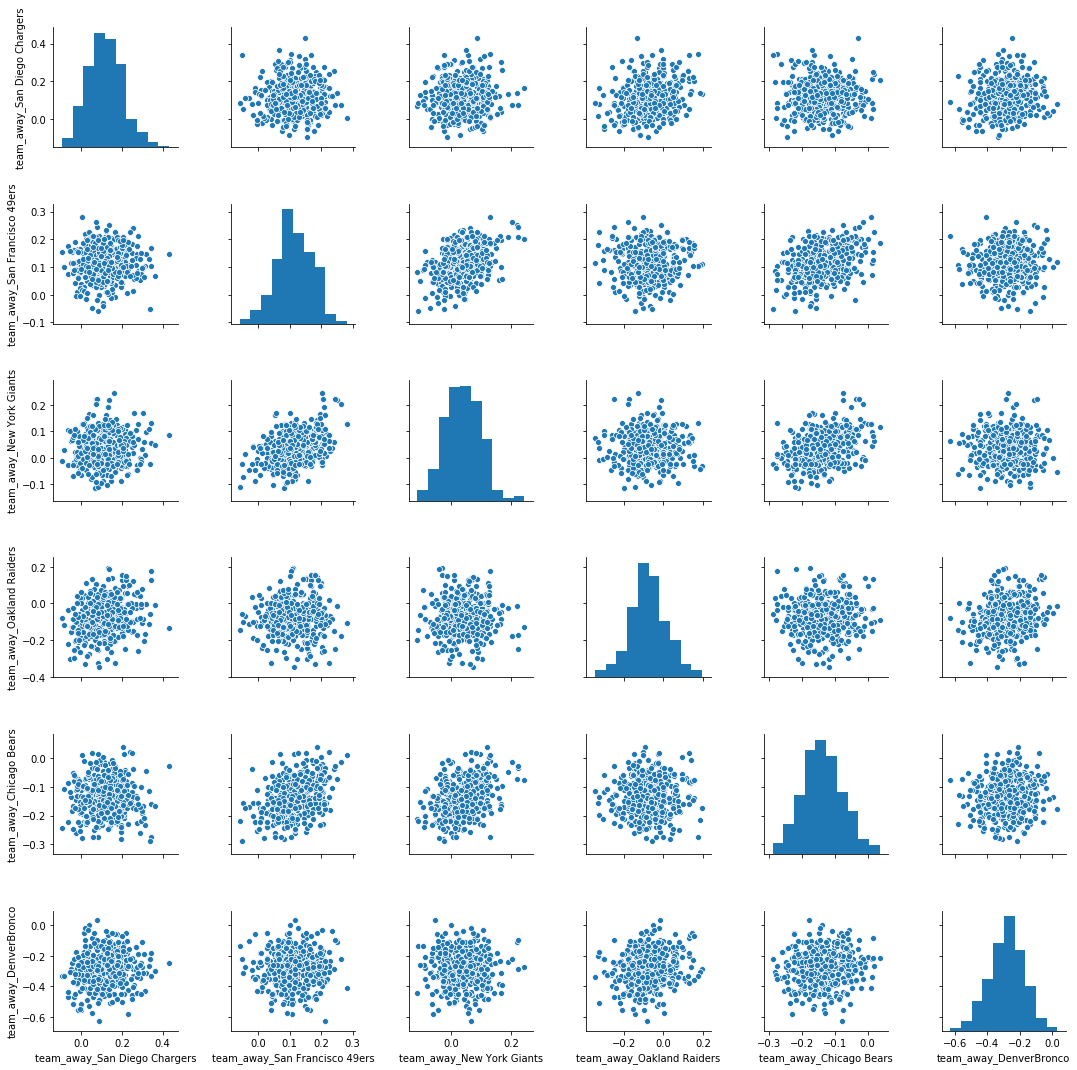

In [88]:
import seaborn as sns

cols = {
    'atts_star__2': 'team_away_San Diego Chargers',
    'atts_star__8': 'team_away_San Francisco 49ers',
    'atts_star__21': 'team_away_New York Giants',
    'atts_star__17': 'team_away_Oakland Raiders',
    'atts_star__22': 'team_away_Chicago Bears',
    'atts_star__14': 'team_away_DenverBronco'
}

df_trace_att = df_trace[list(cols)].rename(columns=cols)
_ = sns.pairplot(df_trace_att)

For Defense:

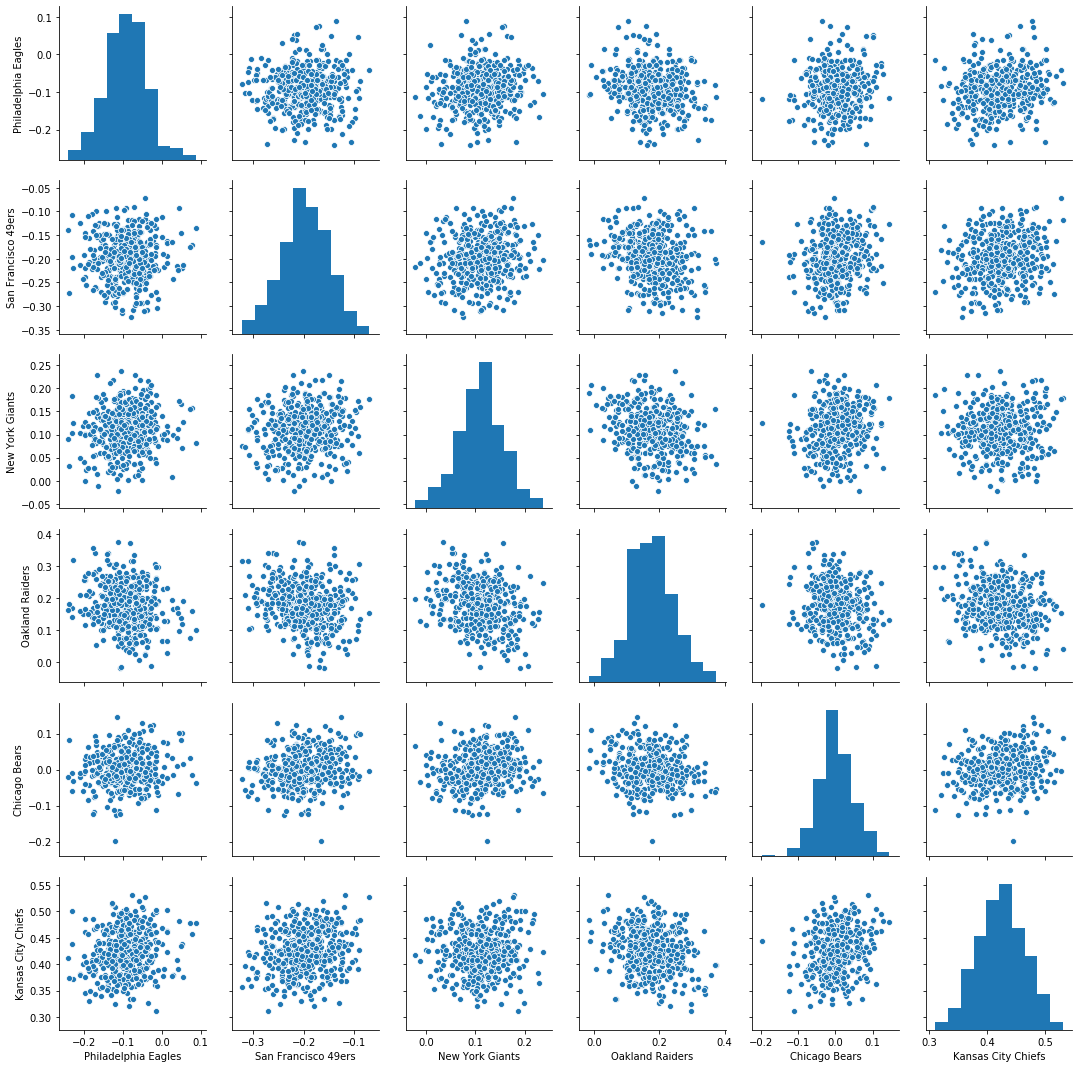

In [86]:
import seaborn as sns

cols = {
    'defs__2': 'Philadelphia Eagles',
    'defs__8': 'San Francisco 49ers',
    'defs__21': 'New York Giants',
    'defs__17': 'Oakland Raiders',
    'defs__22': 'Chicago Bears',
    'defs__14': 'Denver Bronco'
}

df_trace_def = df_trace[list(cols)].rename(columns=cols)
_ = sns.pairplot(df_trace_def)

Thus we used this bayesian estimation model along with MLE for estimating the probability of the team scoring highest points. Our study concludes that team Green Bay Packers have the max probability of scoring highest points over 1966-67 season.